# Partial GT on the 3-hole potential

Since this is a fairly metastable system, escape time distributions from each community should be single-exponential. We can verify that by calculating the waiting time distribution from each of the 5 communities (eventually we will want to cross-check these with the discconectivity graph to understand which community IDs correspond to which funnels). Next, we will test the heuristics that we discovered in the LJ38 example on each community basin escape, and see how partially transforming each basin affects the community <--> community passage time distributions.

All calculations will be done at T=0.6, since that is the temperature used to calculate the communities. Although, the community structure should not change much at different temperatures since the metastability arises from the potential energy function.

In [211]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from pathlib import Path
import seaborn as sns
sns.set()
%matplotlib inline

In [11]:
#function to read Daniel's communities.dat file, modified from ktn_analysis class
#produces selectors akin to AS and BS in Tom's code, but for all N communities
def read_communities(commdat, index_sel):
    """Read in a single column file called communities.dat where each line
    is the community ID (zero-indexed) of the minima given by the line
    number.

    Parameters
    ----------
    commdat : .dat file
        single-column file containing community IDs of each minimum

    Returns
    -------
    communities : dict
        mapping from community ID (0-indexed) to minima ID (0-indexed)
    """

    communities = {}
    with open(commdat, 'r') as f:
        for minID, line in enumerate(f, 0):
            groupID =  int(line) #number from 0 to N-1
            if groupID in communities:
                communities[groupID].append(minID)
            else:
                communities[groupID] = [minID]
            #if minID == 21:
                #print('Community A: ' + str(groupID))
            #if minID == 867:
                #print('Community B: ' + str(groupID))
    
    for ci in range(len(communities)):
        #create a new index_selector to select out the minima in community ci
        keep = np.zeros(index_sel.size,bool)
        keep[communities[ci]] = True
        #re-assign communities[ci] to be the index-selector for the maximally connected component of the graph
        communities[ci] = keep[index_sel]
        #print(f'Community {ci}: {keep.sum()}')
        
    return communities

In [10]:
# index_sel = which states in data file are part of largest connected component and hence are included in KTN
# only states where index_sel = True feature in K,D,B etc. i.e. N = index_sel.sum()
# B: braching prob, K = rates, D = total rate per state, u = energy, s = entropy, Emin = min E, 
data_path = Path("KTN_data/3h")
temp = 0.6
beta = 1./temp
B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
print(K.shape)
#non-csr matrix version of D:
D = np.ravel(K.sum(axis=0)) 
#free energy of minima
BF = beta*u-s
#rescaled
BF -= BF.min()
communities = read_communities(data_path/'communities_3h.dat', index_sel)

N,N_TS: 998 3981
Connected Clusters: 1, 1st 400 states in largest cluster: 1
cc: N: 998->998 (998,) (998,)
(998, 998)
Community A: 2
Community B: 4
Community 0: 160
Community 1: 230
Community 2: 232
Community 3: 205
Community 4: 171


## Basin Escape: Partial-GT vs Full Network

In [45]:
#in kPS, we want to simulate escape trajectories from B -> (I U A)
#so in pre-processing the network, we want to be removing states from the source community (in this case B)
def prune_B(beta, percent_retained_in_B=90., rm_type='free_energy', dopdf=False):
    Nmax = None
    data_path = Path("KTN_data/3h")
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    D = np.ravel(K.sum(axis=0))
    escape_time = 1./D
    BF = beta*u-s
    BF -= BF.min()
    communities = read_communities(data_path/'communities_3h.dat', index_sel)
    #BS is the selector for all nodes in the source community
    results = {}
    for source_commID in communities:
        BS = communities[source_commID]
        print(f'Source comm: {source_commID}, Source nodes: {BS.sum()}')

        """ First calculate p(t), <tau>, <tau^2> without any GT"""
        #<tau_B>, <tau^2_B>
        tau = np.zeros(2)
        if dopdf:
            # time*tau_range, p(t), p(t)_gt (first 3: A->B, second 3: B->A)
            pt = np.zeros((3,400))

        #B -> A U I
        rho = np.exp(-BF) * BS
        rho /= rho.sum()
        Q = (diags(D)-K)[BS,:][:,BS]
        x = spsolve(Q,rho[BS])
        y = spsolve(Q,x)
        tau[0] = x.sum()
        tau[1] = 2.0*y.sum()
        if dopdf:
            pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
            nu,v,w = spla.eig(Q.todense(),left=True)
            dp = np.sqrt(np.diagonal(w.T.dot(v))).real
            v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[BS])
            w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
            nu = nu.real
            pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()

        """Now calculate <tau>, <tau^2>, p(t) after graph transforming away the top 10% of B nodes"""

        rm_reg = np.zeros(N,bool)
        if rm_type == 'free_energy':
            rm_reg[BS] = BF[BS]>np.percentile(BF[BS],percent_retained_in_B)
        if rm_type == 'escape_time':
            #remove nodes with the smallest escape times
            #retain nodes in the top percent_retained percentile of escape time
            rm_reg[BS] = escape_time[BS] < np.percentile(escape_time[BS], 100.0 - percent_retained_in_B)
        if rm_type == 'hybrid':
            #remove nodes in the top percent_retained percentile of escape time
            time_sel = (escape_time[BS] < np.percentile(escape_time[BS], 100.0 - percent_retained_in_B))
            bf_sel = (BF[BS]>np.percentile(BF[BS],percent_retained_in_B))
            sel = np.bitwise_and(time_sel, bf_sel)
            #that are also in the lowest percent_retained percentile of free energy
            rm_reg[BS] = sel
        #free energies of retained states
        r_BF = BF[~rm_reg]
        print(f'Nodes to eliminate: {rm_reg.sum()}')

        #<tau_B>, <tau^2_B>
        gttau = np.zeros(2)

        #B -> A
        rho = (np.exp(-BF) * BS)[~rm_reg] / (np.exp(-BF) * BS).sum()
        RBS = BS[~rm_reg]
        GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]
        Q = GT_Q[:,RBS][RBS,:]
        x = spsolve(Q,rho[RBS])
        y = spsolve(Q,x)
        gttau[0] = x.sum()
        gttau[1] = 2.0*y.sum()
        if dopdf:
            nu,v,w = spla.eig(Q.todense(),left=True)
            dp = np.sqrt(np.diagonal(w.T.dot(v))).real
            v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[RBS])
            w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
            nu = nu.real
            pt[2] = (v*w*nu)@np.exp(-np.outer(nu,pt[0])) * (v*w/nu).sum()
    
        if dopdf:
            results[source_commID] = (beta,tau,gttau,pt)
        else:
            results[source_commID] = (beta,tau,gttau)
    return results

In [20]:
#plot all 5 escape time distributions
def plot_escapeB_pt(results, tag=''):
    fig, ax = plt.subplots(1, 5, figsize=(15,3),dpi=120)#,sharex='col')
    for j in range(len(results)):
        beta, tau, gttau, pt = results[j]
        ax[j].set_title(f"Escape from {j}, T={(1.0/beta):.2f}")
        names=["AUI","B"]
        ax[j].plot(pt[0]/tau[0],pt[1],'C0-',lw=3,label=r"Full $P(\tau)$")
        ax[j].plot(pt[0]/tau[0],pt[2],'C1-.',lw=3,label=r"$P^{GT}(\tau)$")
        ax[j].legend()
        ax[j].set_yscale("log")
        ax[j].set_xscale("log")
        ax[j].set_xlim(0.001,1000.)
        if j==2:
            ax[j].set_xlabel(r"$\tau/\langle\tau\rangle$")
        if j==0:
            ax[j].set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
        #ax.set_ylim(pt[1].min()/10.0,100.0)
    plt.tight_layout()


N,N_TS: 998 3981
Source comm: 0, Source nodes: 160
Nodes to eliminate: 146
Source comm: 1, Source nodes: 230
Nodes to eliminate: 207
Source comm: 4, Source nodes: 171
Nodes to eliminate: 153
Source comm: 3, Source nodes: 205
Nodes to eliminate: 185
Source comm: 2, Source nodes: 232
Nodes to eliminate: 208


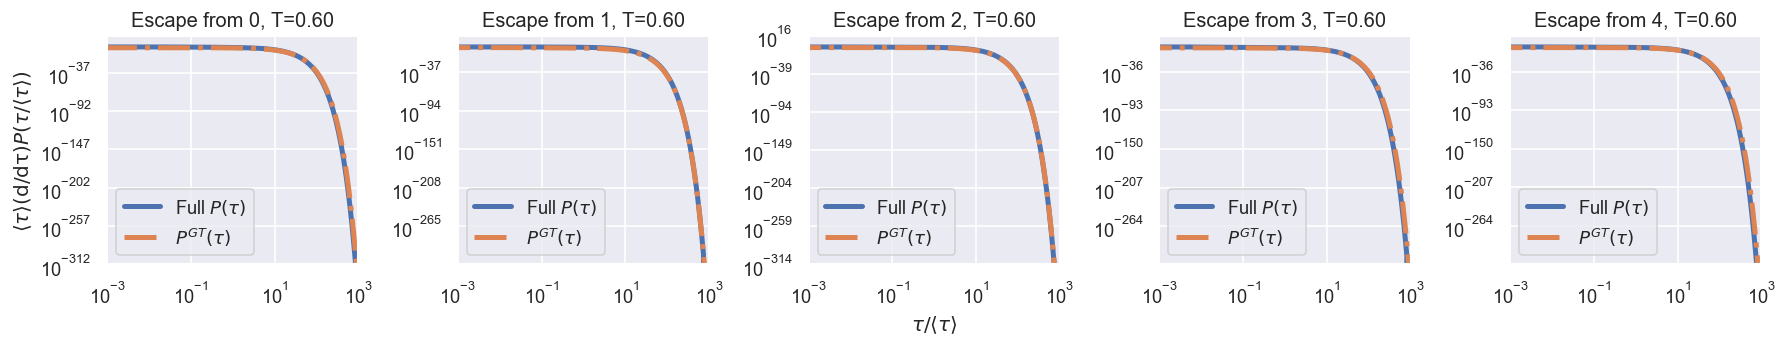

In [48]:
#hybrid approach, retaining 10% lowest free energy, most long-lived states
_beta = 1.0/0.6
results_full = prune_B(_beta, percent_retained_in_B=5., rm_type='hybrid', dopdf=True)
plot_escapeB_pt(results_full)

N,N_TS: 998 3981
Source comm: 0, Source nodes: 160
Nodes to eliminate: 144
Source comm: 1, Source nodes: 230
Nodes to eliminate: 207
Source comm: 4, Source nodes: 171
Nodes to eliminate: 153
Source comm: 3, Source nodes: 205
Nodes to eliminate: 184
Source comm: 2, Source nodes: 232
Nodes to eliminate: 208


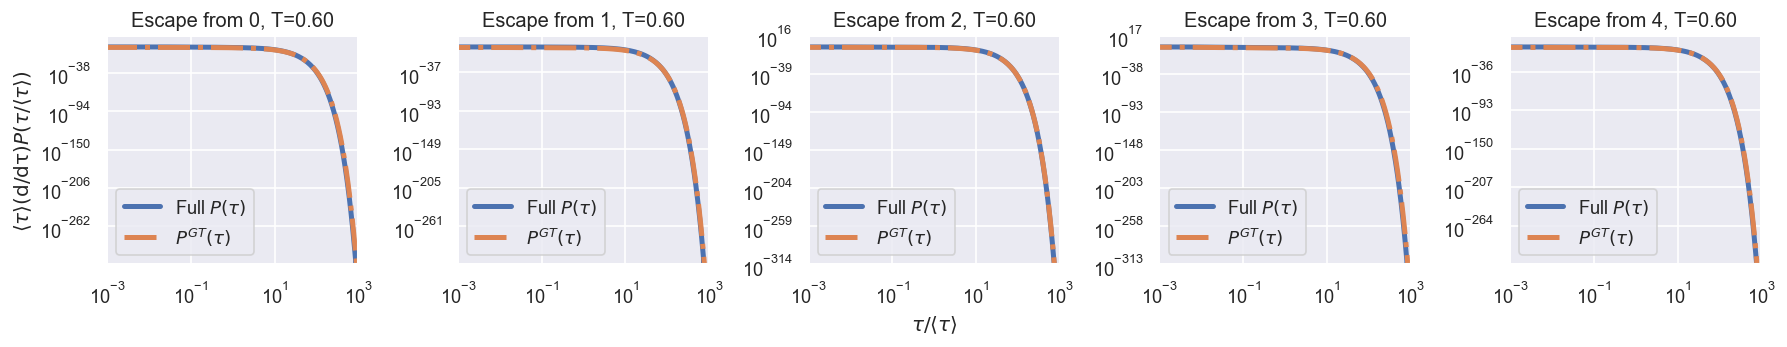

In [49]:
#retaining 10% lowest free energy states
_beta = 1.0/0.6
bf_results = prune_B(_beta, percent_retained_in_B=10., rm_type='free_energy', dopdf=True)
plot_escapeB_pt(bf_results)

N,N_TS: 998 3981
Source comm: 0, Source nodes: 160
Nodes to eliminate: 144
Source comm: 1, Source nodes: 230
Nodes to eliminate: 207
Source comm: 4, Source nodes: 171
Nodes to eliminate: 153
Source comm: 3, Source nodes: 205
Nodes to eliminate: 184
Source comm: 2, Source nodes: 232
Nodes to eliminate: 208


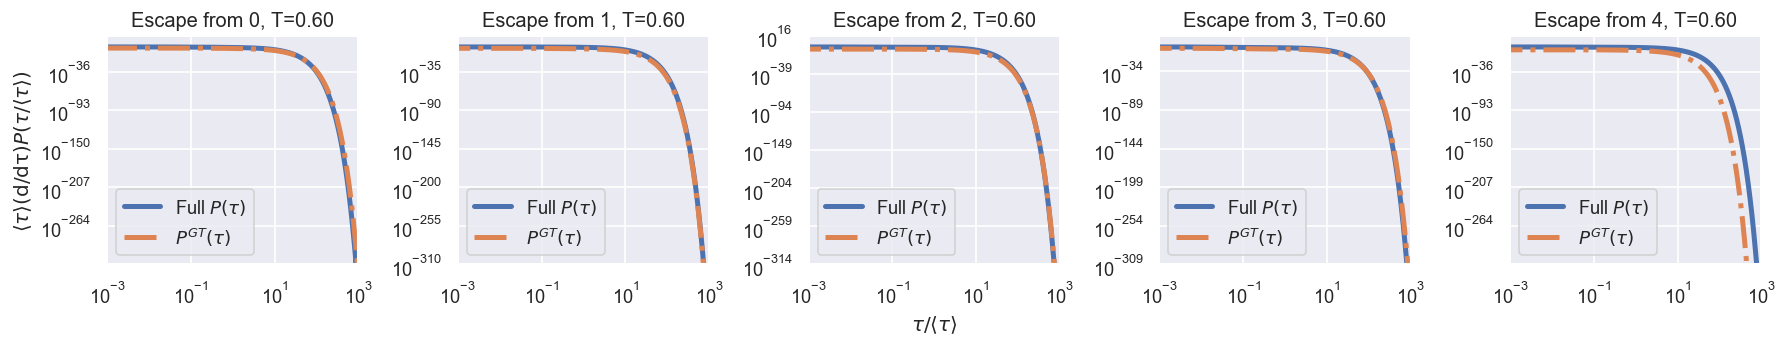

In [50]:
#retaining 10% most long-lived states
_beta = 1.0/0.6
time_results = prune_B(_beta, percent_retained_in_B=10., rm_type='escape_time', dopdf=True)
plot_escapeB_pt(time_results)

We confirm that escape from all 5 basins is single-exponential, and that graph-transforming 90% of the nodes using either of the above 3 heuristics (free energy, escape time, hybrid approach) mostly retains the escape distribtuion.

## Sequential partial GT: reducing each basin at a time

In [103]:
def prune_B_sequential(beta, percent_retained_in_B=90., rm_type='free_energy', dopdf=False):
    Nmax = None
    data_path = Path("KTN_data/3h")
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    D = np.ravel(K.sum(axis=0))
    Q = diags(D)-K
    N_og = N #original size of network
    escape_time = 1./D
    BF = beta*u-s
    BF -= BF.min()
    communities = read_communities(data_path/'communities_3h.dat', index_sel)
    #BS is the selector for all nodes in the source community
    results = {}
    #selector of size (998,) where 'True' elements are still remaining as network gets reduced
    #rm_from_og = np.zeros(N_og,bool)
    
    for source_commID in communities:
        print(N, Q.shape, D.shape, communities[source_commID].shape)
        BS = communities[source_commID]
        print(f'Source comm: {source_commID}, Source nodes: {BS.sum()}')

        """ First calculate p(t), <tau>, <tau^2> of reduced network before GT on current basin"""
        #<tau_B>, <tau^2_B>
        tau = np.zeros(2)
        if dopdf:
            # time*tau_range, p(t), p(t)_gt (first 3: A->B, second 3: B->A)
            pt = np.zeros((3,400))

        #B -> A U I
        rho = np.exp(-BF) * BS
        rho /= rho.sum()
        Q = Q[BS,:][:,BS]
        x = spsolve(Q,rho[BS])
        y = spsolve(Q,x)
        tau[0] = x.sum()
        tau[1] = 2.0*y.sum()
        if dopdf:
            pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
            nu,v,w = spla.eig(Q.todense(),left=True)
            dp = np.sqrt(np.diagonal(w.T.dot(v))).real
            v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[BS])
            w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
            nu = nu.real
            pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()

        """Now calculate <tau>, <tau^2>, p(t) after graph transforming away the top 10% of B nodes"""

        rm_reg = np.zeros(N,bool)
        if rm_type == 'free_energy':
            rm_reg[BS] = BF[BS]>np.percentile(BF[BS],percent_retained_in_B)
        if rm_type == 'escape_time':
            #remove nodes with the smallest escape times
            #retain nodes in the top percent_retained percentile of escape time
            rm_reg[BS] = escape_time[BS] < np.percentile(escape_time[BS], 100.0 - percent_retained_in_B)
        if rm_type == 'hybrid':
            #remove nodes in the top percent_retained percentile of escape time
            time_sel = (escape_time[BS] < np.percentile(escape_time[BS], 100.0 - percent_retained_in_B))
            bf_sel = (BF[BS]>np.percentile(BF[BS],percent_retained_in_B))
            sel = np.bitwise_and(time_sel, bf_sel)
            #that are also in the lowest percent_retained percentile of free energy
            rm_reg[BS] = sel
        
        print(f'Nodes to eliminate: {rm_reg.sum()}')
        #rm_from_og[~rm_reg] = True
        #<tau_B>, <tau^2_B>
        gttau = np.zeros(2)

        #B -> A U I
        rho = (np.exp(-BF) * BS)[~rm_reg] / (np.exp(-BF) * BS).sum()
        RBS = BS[~rm_reg]
        B, D, Q, N, retry = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)
        GT_Q = Q[:,RBS][RBS,:]
        x = spsolve(GT_Q,rho[RBS])
        y = spsolve(GT_Q,x)
        gttau[0] = x.sum()
        gttau[1] = 2.0*y.sum()
        if dopdf:
            nu,v,w = spla.eig(GT_Q.todense(),left=True)
            dp = np.sqrt(np.diagonal(w.T.dot(v))).real
            v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[RBS])
            w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
            nu = nu.real
            pt[2] = (v*w*nu)@np.exp(-np.outer(nu,pt[0])) * (v*w/nu).sum()
        
        #free energies and escape times of retained states
        BF = BF[~rm_reg]
        #note this is still the escape times from original network
        #a nother possibility is to re-compute escape_time with 1./D
        #escape_time = escape_time[~rm_reg]
        escape_time = 1./D
        
        #community selectors in reduced network -- update shapes
        for com in communities:
            communities[com] = communities[com][~rm_reg]
            
        if dopdf:
            results[source_commID] = (beta,tau,gttau,pt)
        else:
            results[source_commID] = (beta,tau,gttau)
            
    return results, B, D, Q, N, BF, communities

In [154]:
#hybrid approach, retaining 20% lowest free energy, most long-lived states
_beta = 1.0/0.6
results, B, D, Q_hybrid20, N_hybrid20, BF_hybrid20, communities_hybrid20 = prune_B_sequential(_beta, percent_retained_in_B=10., rm_type='hybrid', dopdf=True)
print(N_hybrid20, Q_hybrid20.shape, BF_hybrid20.shape)

N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 165
382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
197 (197, 197) (197,)


In [192]:
#now compare final reduced network (with only 10% of nodes) to original escape time distributions
#compute escape time distributions from each basin in reduced network
def compute_escape_stats(BS, BF, Q, dopdf=True):
    #<tau>, <tau^2>
    tau = np.zeros(2)
    if dopdf:
        # time*tau_range, p(t)
        pt = np.zeros((2, 400))
    rho = np.exp(-BF) * BS
    rho /= rho.sum()
    Q = Q[BS,:][:,BS]
    x = spsolve(Q,rho[BS])
    y = spsolve(Q,x)
    tau[0] = x.sum()
    tau[1] = 2.0*y.sum()
    if dopdf:
        pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[BS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
        return tau, pt
    else:
        return tau

In [113]:
#plot all 5 escape time distributions
def plot_escapeB_full_vs_reduced(results_full, BF, Q, communities, ratio=False):
    fig, ax = plt.subplots(1, 5, figsize=(15,3),dpi=120)#,sharex='col')
    for j in range(len(communities)):
        beta, tau_full, gttau_full, pt_full = results_full[j]
        tau, pt = compute_escape_stats(communities[j], BF, Q)
        print(f'Basin {j}')
        print(f'Mean waiting time reduced/full: {tau[0]/tau_full[0]}')
        print(f'Std. waiting time reduced/full: {tau[1]/tau_full[1]}')
        ax[j].set_title(f"Escape from {j}, T={(1.0/beta):.2f}")
        if ratio:
            arr1 = pt[0]/tau[0]
            arr2 = pt_full[0]/tau[0]
            ax[j].plot(arr2, pt[1]/pt_full[1], 'C0-', lw=3, label=r"$P^{GT}(\tau)/P(\tau)$")
        else:
            #full escape time distribution
            ax[j].plot(pt_full[0]/tau_full[0],pt_full[1],'C0-',lw=3,label=r"Full $P(\tau)$")
            #basin escape in reduced network
            ax[j].plot(pt[0]/tau[0],pt[1],'C1-.',lw=3,label=r"$P^{GT}(\tau)$")
        ax[j].legend()
        ax[j].set_yscale("log")
        ax[j].set_xscale("log")
        ax[j].set_xlim(0.001,1000.)
        if j==2:
            ax[j].set_xlabel(r"$\tau/\langle\tau\rangle$")
        if j==0:
            ax[j].set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
        #ax.set_ylim(pt[1].min()/10.0,100.0)
    plt.tight_layout()

Basin 0
Mean waiting time reduced/full: 1.1485375920950391
Std. waiting time reduced/full: 1.2208813198607857
Basin 1
Mean waiting time reduced/full: 1.042012036702795
Std. waiting time reduced/full: 1.0765338263301227
Basin 2
Mean waiting time reduced/full: 1.0347470134119812
Std. waiting time reduced/full: 1.0578601926052598
Basin 3
Mean waiting time reduced/full: 1.1048260399019245
Std. waiting time reduced/full: 1.1657690406364143
Basin 4
Mean waiting time reduced/full: 1.1217841692250987
Std. waiting time reduced/full: 1.1814231934070654


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


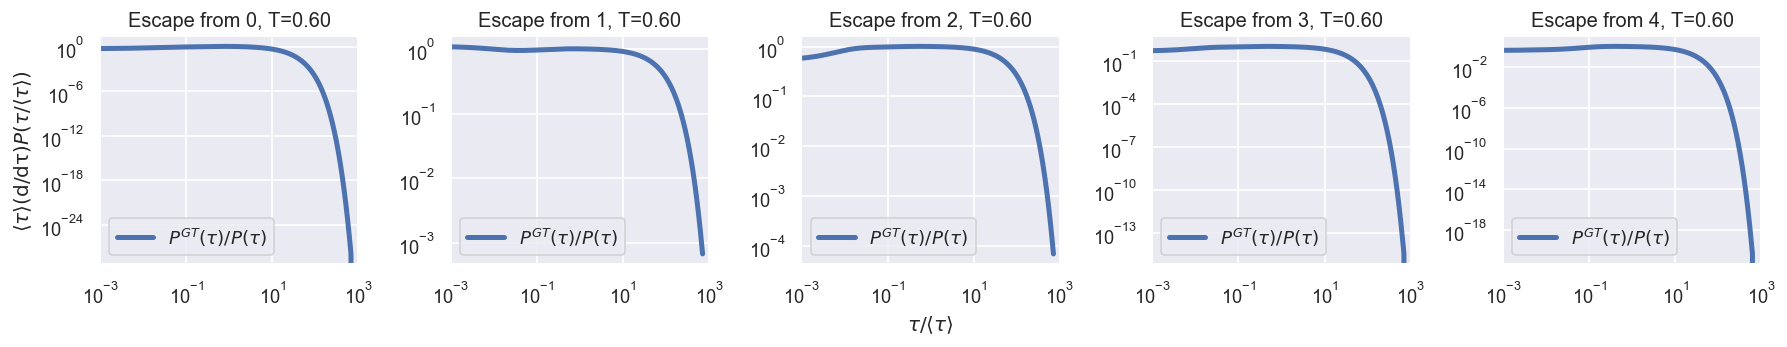

In [135]:
plot_escapeB_full_vs_reduced(results_full, BF, Q, communities, ratio=True)

In [153]:
#retaining 20% lowest free energy states
_beta = 1.0/0.6
results, B, D, Q_free20, N_free20, BF_free20, communities_free20 = prune_B_sequential(_beta, percent_retained_in_B=20., rm_type='free_energy', dopdf=True)
print(N_free20, Q_free20.shape, BF_free20.shape)

N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
201 (201, 201) (201,)


Basin 0
Mean waiting time reduced/full: 1.5402001024785705
Std. waiting time reduced/full: 2.2103410593278014
Basin 1
Mean waiting time reduced/full: 1.5353967893273024
Std. waiting time reduced/full: 2.3441803450231853
Basin 2
Mean waiting time reduced/full: 1.0324681358250938
Std. waiting time reduced/full: 1.0578900093284862
Basin 3
Mean waiting time reduced/full: 1.135114646935633
Std. waiting time reduced/full: 1.2567386893172787
Basin 4
Mean waiting time reduced/full: 1.1027562542758373
Std. waiting time reduced/full: 1.1782970570441307


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


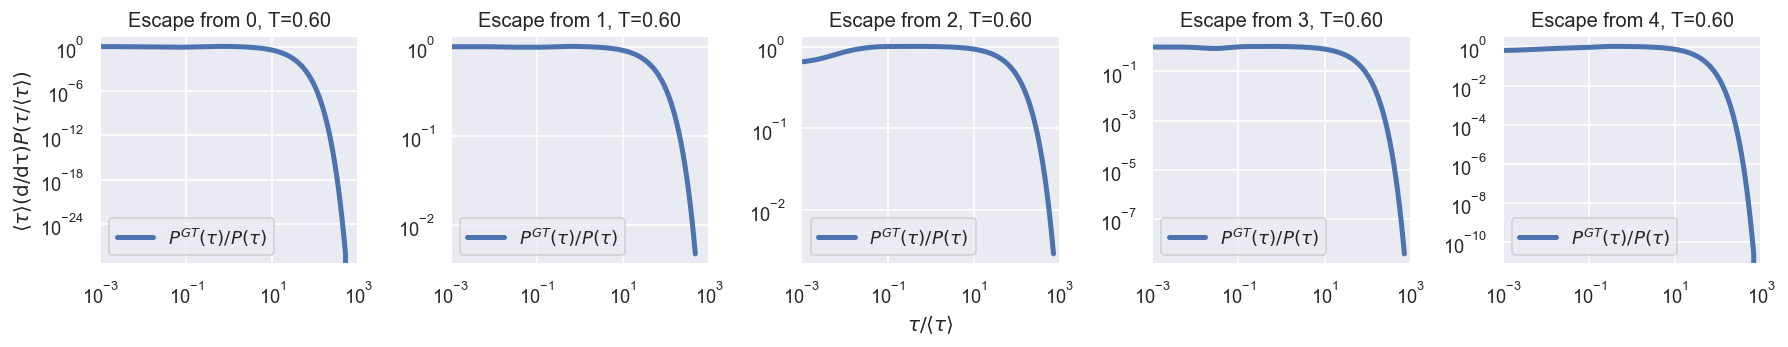

In [137]:
plot_escapeB_full_vs_reduced(results_full, BF, Q, communities, ratio=True)

In [138]:
#retaining 20% most long lived states
_beta = 1.0/0.6
results, B, D, Q, N, BF, communities = prune_B_sequential(_beta, percent_retained_in_B=20., rm_type='escape_time', dopdf=True)
print(N, Q.shape, BF.shape)

N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
201 (201, 201) (201,)


Basin 0
Mean waiting time reduced/full: 1.1295513821924128
Std. waiting time reduced/full: 1.2293368192569814
Basin 1
Mean waiting time reduced/full: 0.9377425047865074
Std. waiting time reduced/full: 0.9419434712786939
Basin 2
Mean waiting time reduced/full: 4.241601342440702
Std. waiting time reduced/full: 18.666780628606702
Basin 3
Mean waiting time reduced/full: 1.0257259615691798
Std. waiting time reduced/full: 1.092155173834127
Basin 4
Mean waiting time reduced/full: 1.1661448014918667
Std. waiting time reduced/full: 1.4484774949205985


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


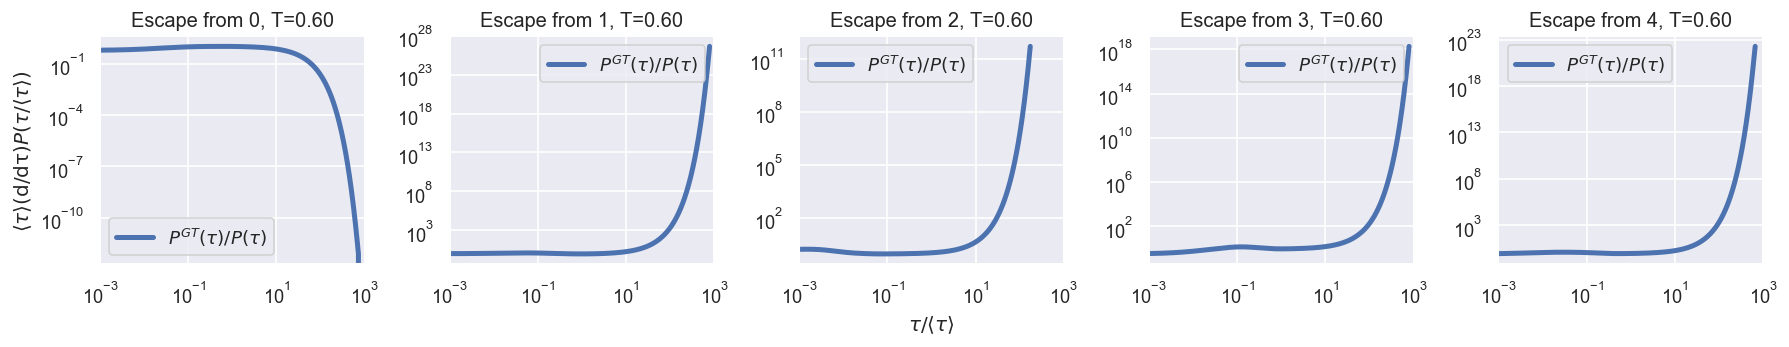

In [139]:
plot_escapeB_full_vs_reduced(results_full, BF, Q, communities, ratio=True)

* In this system, it seems that retaining the lowest free energy states in each basin is more accurate than the hybrid approach or selecting the longest lived states. However, the hybrid approach led to the most accurate estimation of the 1st and 2nd moments of the escape time for all basins (like in LJ38)
* All schemes are most errnoeous in basins 0 and 4, followed by basin 3. basins 1 and 2 had the least error.
* This illustrates that uniformly removing a certain percentile of states per basin might not be the best approach. perhaps most of the states in the smaller/less metastable funnels should be retained, and the larger more metastable funnels can affort to be pruned more.

### Community <-> community MFPTs in reduced network

In [179]:
#now compare final reduced network to original passage time distributions
#compute passage time distributions from basin I to basin J in reduced network
def compute_passage_stats(AS, BS, BF, Q, dopdf=True):
    #<tauAB>, <tau^2AB>, <tauBA>, <tau^2BA>
    tau = np.zeros(4)
    if dopdf:
        # time*tau_range, p(t) (first 2: A->B, second 2: B->A)
        pt = np.zeros((4,400))
        
    #A -> B
    rho = np.exp(-BF) * AS
    rho /= rho.sum()
    #B is absorbing, so we want Q in space of A U I
    M = Q[~BS,:][:,~BS]
    x = spsolve(M,rho[~BS])
    y = spsolve(M,x)
    tau[0] = x.sum()
    tau[1] = 2.0*y.sum()
    if dopdf:
        pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
        nu,v,w = spla.eig(M.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~BS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
    
    #B -> A
    rho = np.exp(-BF) * BS
    rho /= rho.sum()
    M = Q[~AS,:][:,~AS]
    x = spsolve(M,rho[~AS])
    y = spsolve(M,x)
    tau[2] = x.sum()
    tau[3] = 2.0*y.sum()
    if dopdf:
        pt[2] = np.logspace(-6,3,pt.shape[1])*tau[2]
        nu,v,w = spla.eig(M.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~AS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
    
    if dopdf:
        return tau, pt
    else:
        return tau

In [180]:
#plot full A<->B passage time distributions vs. in GT-reduced network
#plot all 5 escape time distributions
def plot_ptAB_full_vs_reduced(c1, c2, comms_reduced, BF_reduced, Q_reduced, beta=1.0/0.6, ratio=False):
    #first compute c1<->c2 passage time distributions on full network
    data_path = Path("KTN_data/3h")
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    D = np.ravel(K.sum(axis=0))
    Q = diags(D)-K
    BF = beta*u-s
    BF -= BF.min()
    communities = read_communities(data_path/'communities_3h.dat', index_sel)
    tau_full, pt_full = compute_passage_stats(communities[c1], communities[c2], BF, Q)
    #now compute c1<->c2 passage time distributions on reduced network
    tau, pt = compute_passage_stats(comms_reduced[c1], comms_reduced[c2], BF_reduced, Q_reduced)
    print(f'MFPT {c1}->{c2} reduced/full: {tau[0]/tau_full[0]}')
    print(f'sigma {c1}->{c2} reduced/full: {tau[1]/tau_full[1]}')
    print(f'MFPT {c2}->{c1} reduced/full: {tau[2]/tau_full[2]}')
    print(f'sigma {c2}->{c1} reduced/full: {tau[3]/tau_full[3]}')
    names = [c1, c2]
    fig, ax = plt.subplots(1, 2, figsize=(12,4),dpi=120)#,sharex='col')
    for j in range(2):
        ax[j].set_title(f"{names[j]} --> {names[1-j]}, T={(1.0/beta):.2f}")
        if ratio:
            arr1 = pt[2*j]/tau[2*j]
            arr2 = pt_full[2*j]/tau[2*j]
            ax[j].plot(arr2, pt[2*j+1]/pt_full[2*j+1], 'C0-', lw=3, label=r"$P^{GT}(\tau)/P(\tau)$")
        else:
            #full escape time distribution
            ax[j].plot(pt_full[2*j]/tau_full[2*j],pt_full[2*j+1],'C0-',lw=3,label=r"Full $P(\tau)$")
            #basin escape in reduced network
            ax[j].plot(pt[2*j]/tau[2*j],pt[2*j+1],'C1-.',lw=3,label=r"$P^{GT}(\tau)$")
        ax[j].legend()
        ax[j].set_yscale("log")
        ax[j].set_xscale("log")
        ax[j].set_xlim(0.001,1000.)
        ax[j].set_xlabel(r"$\tau/\langle\tau\rangle$")
        if j==0:
            ax[j].set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
        #ax.set_ylim(pt[1].min()/10.0,100.0)
    plt.tight_layout()

In [183]:
#calculate ratio of MFPT in reduced network to full network for all pairs of communities
#same for the second moment
def get_first_second_moment_ratios_reduced_full(comms_reduced, BF_reduced, Q_reduced, beta=1.0/0.6):
    #first compute c1<->c2 passage time distributions on full network
    data_path = Path("KTN_data/3h")
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    D = np.ravel(K.sum(axis=0))
    Q = diags(D)-K
    BF = beta*u-s
    BF -= BF.min()
    communities = read_communities(data_path/'communities_3h.dat', index_sel)
    ncomms = len(communities)
    #i <- j <tau> and <tau^2> ratios for reduced/full
    mfpt_mat = np.ones((ncomms, ncomms))
    std_mat = np.ones((ncomms, ncomms))
    for c1 in communities:
        for c2 in communities:
            if c1 < c2:
                #update matrices
                tau_full = compute_passage_stats(communities[c1], communities[c2], BF, Q, dopdf=False)
                #now compute c1<->c2 passage time distributions on reduced network
                tau = compute_passage_stats(comms_reduced[c1], comms_reduced[c2], BF_reduced, 
                                                Q_reduced, dopdf=False)
                #c2 <- c1
                mfpt_mat[c2][c1] = tau[0]/tau_full[0]
                std_mat[c2][c1] = tau[1]/tau_full[1]
                #c1 <-c2
                mfpt_mat[c1][c2] = tau[2]/tau_full[2]
                std_mat[c1][c2] = tau[3]/tau_full[3]
    return mfpt_mat, std_mat

N,N_TS: 998 3981
MFPT 1->2 reduced/full: 5.676781072925142
sigma 1->2 reduced/full: 36.907055760304985
MFPT 2->1 reduced/full: 1.1622702966151448
sigma 2->1 reduced/full: 1.3637509289297594


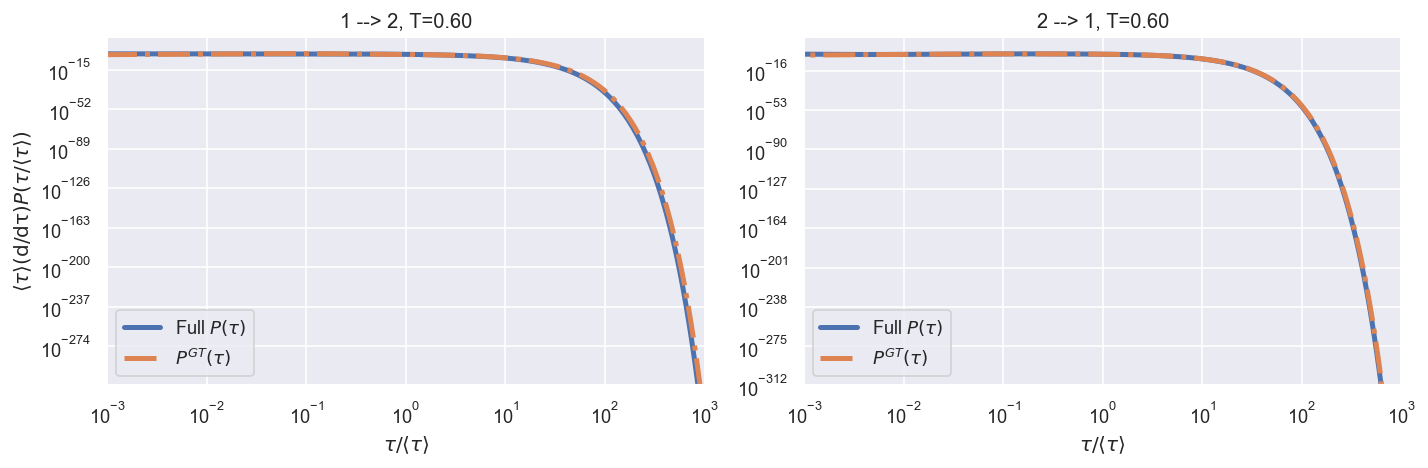

In [151]:
plot_ptAB_full_vs_reduced(1, 2, communities_free20, BF_free20, Q_free20)

N,N_TS: 998 3981
MFPT 1->2 reduced/full: 5.676781072925142
sigma 1->2 reduced/full: 36.907055760304985
MFPT 2->1 reduced/full: 1.1622702966151448
sigma 2->1 reduced/full: 1.3637509289297594


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


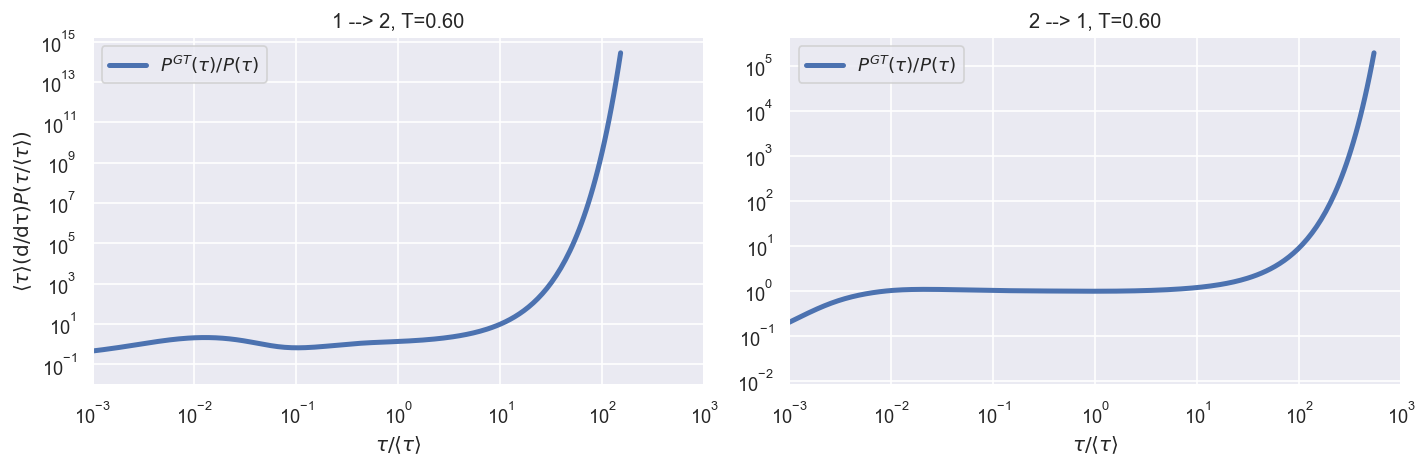

In [152]:
plot_ptAB_full_vs_reduced(1, 2, communities_free20, BF_free20, Q_free20, ratio=True)

N,N_TS: 998 3981
MFPT 1->2 reduced/full: 1.0204534186868732
sigma 1->2 reduced/full: 1.0311898690257166
MFPT 2->1 reduced/full: 1.1211020646877496
sigma 2->1 reduced/full: 1.2708549947079397


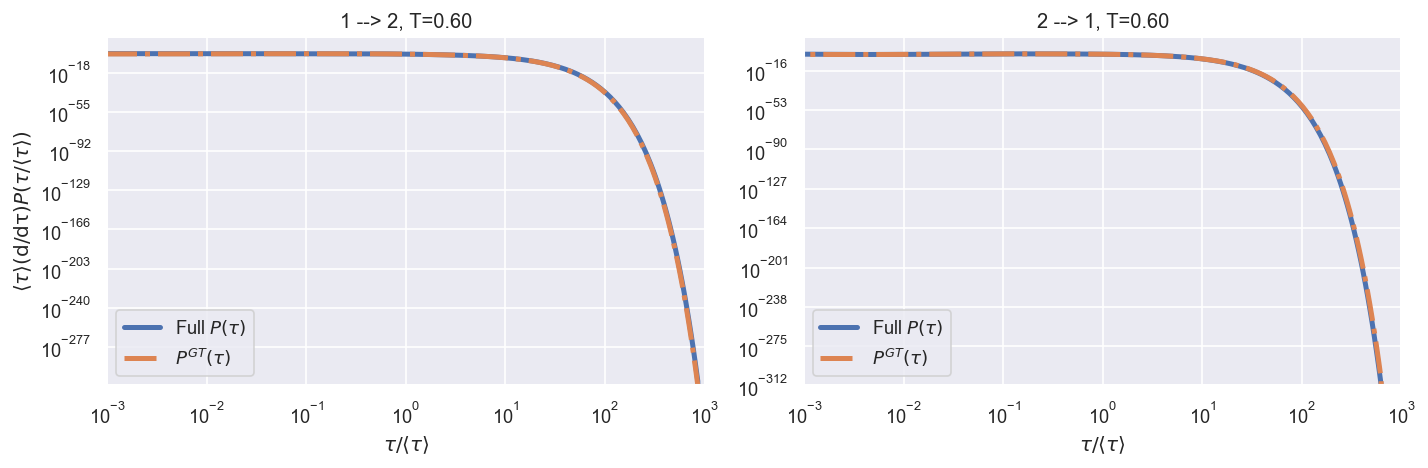

In [155]:
plot_ptAB_full_vs_reduced(1, 2, communities_hybrid20, BF_hybrid20, Q_hybrid20)

N,N_TS: 998 3981
MFPT 1->2 reduced/full: 1.0204534186868732
sigma 1->2 reduced/full: 1.0311898690257166
MFPT 2->1 reduced/full: 1.1211020646877496
sigma 2->1 reduced/full: 1.2708549947079397


/Users/deepti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


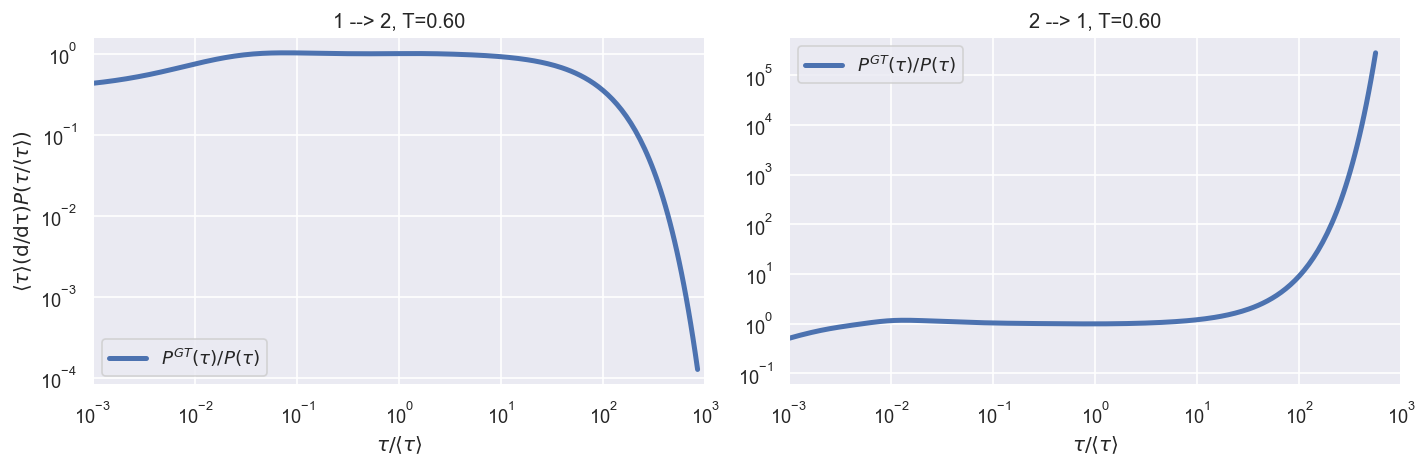

In [156]:
plot_ptAB_full_vs_reduced(1, 2, communities_hybrid20, BF_hybrid20, Q_hybrid20, ratio=True)

N,N_TS: 998 3981
MFPT 2->4 reduced/full: 1.0189633394718203
sigma 2->4 reduced/full: 1.0328781298463223
MFPT 4->2 reduced/full: 1.022933284440708
sigma 4->2 reduced/full: 1.0328310421718607


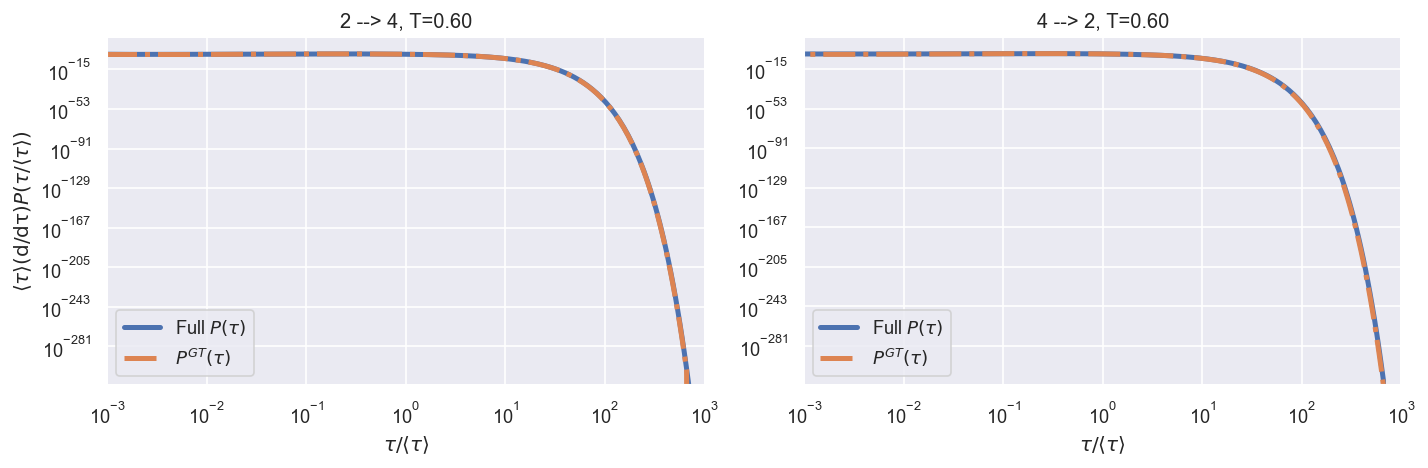

In [158]:
plot_ptAB_full_vs_reduced(2, 4, communities_hybrid20, BF_hybrid20, Q_hybrid20, ratio=False)

N,N_TS: 998 3981
MFPT 2->4 reduced/full: 1.1852349593904572
sigma 2->4 reduced/full: 1.387799950514521
MFPT 4->2 reduced/full: 5.760800431032488
sigma 4->2 reduced/full: 33.78655179876


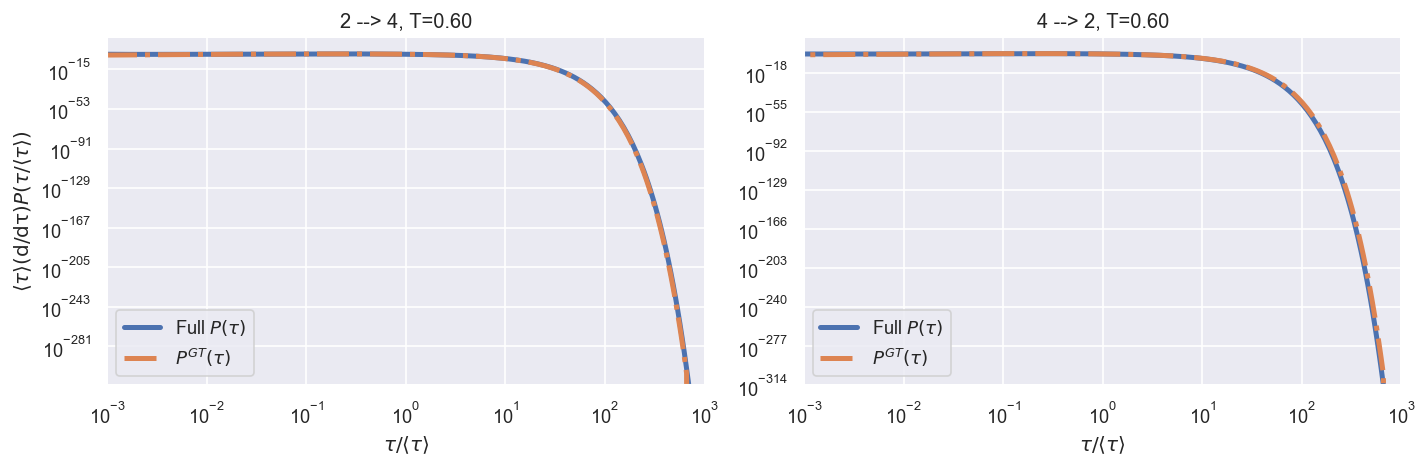

In [159]:
plot_ptAB_full_vs_reduced(2, 4, communities_free20, BF_free20, Q_free20, ratio=False)

* Like for escape time stats, the hybrid approach preserves MFPT and sigma between all pairs of communities; whereas the free energy approach gets one direction off by 5-36fold. 
* The hybrid approach also gets the full distribution right more accurately.

N,N_TS: 998 3981
MFPT 0->4 reduced/full: 1.1791594418062545
sigma 0->4 reduced/full: 1.4285623374361682
MFPT 4->0 reduced/full: 1.0600502951065374
sigma 4->0 reduced/full: 1.2110206756022421


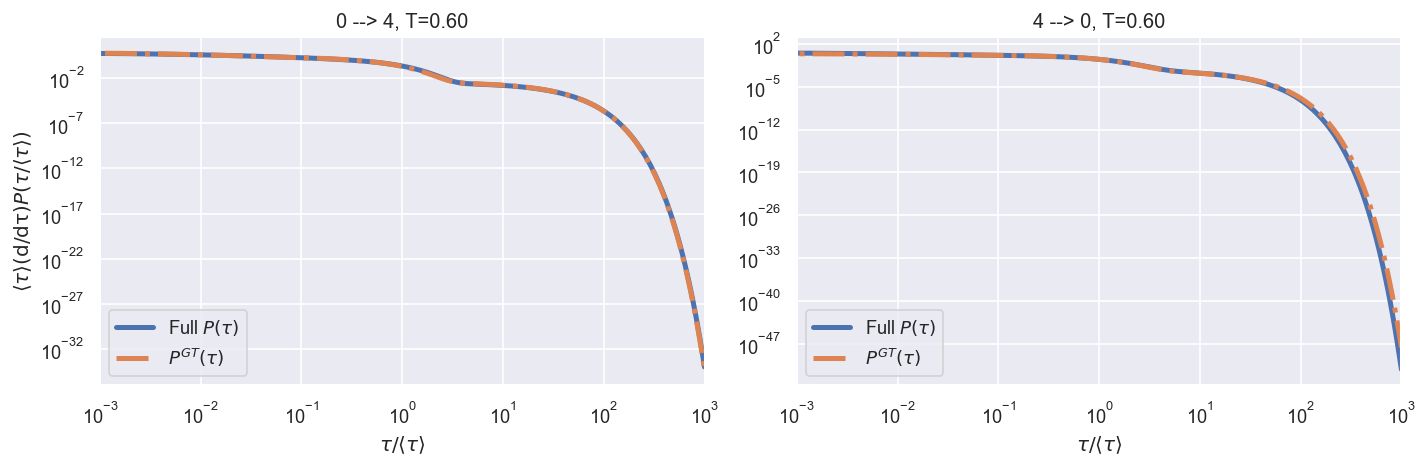

In [165]:
#try on the two problematic basins (0 and 4)
plot_ptAB_full_vs_reduced(0, 4, communities_free20, BF_free20, Q_free20, ratio=False)

* Interesting, the 0<->4 passage time distributions have two timescales, but the reduced network gets them right using the free energy heuristic.

N,N_TS: 998 3981
MFPT 0->4 reduced/full: 1.0929894526828392
sigma 0->4 reduced/full: 1.074843487260073
MFPT 4->0 reduced/full: 1.102597692560123
sigma 4->0 reduced/full: 1.2621291303671105


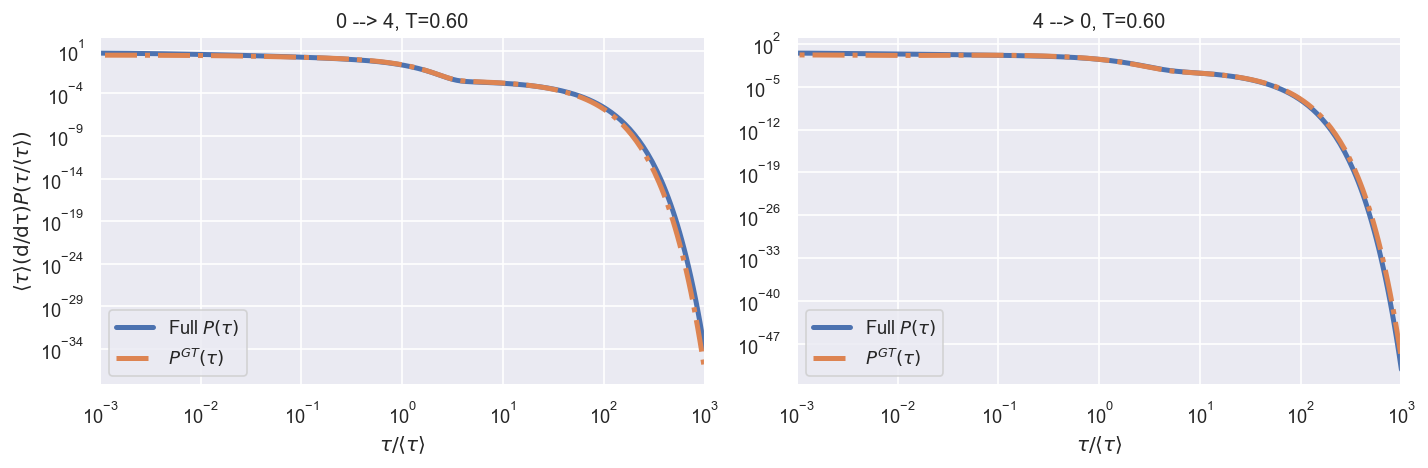

In [164]:
#try on the two problematic basins (0 and 4)
plot_ptAB_full_vs_reduced(0, 4, communities_hybrid20, BF_hybrid20, Q_hybrid20, ratio=False)

N,N_TS: 998 3981
MFPT 1->3 reduced/full: 0.9491360706425285
sigma 1->3 reduced/full: 0.9472515325098053
MFPT 3->1 reduced/full: 1.2160753297200022
sigma 3->1 reduced/full: 1.427059409122572


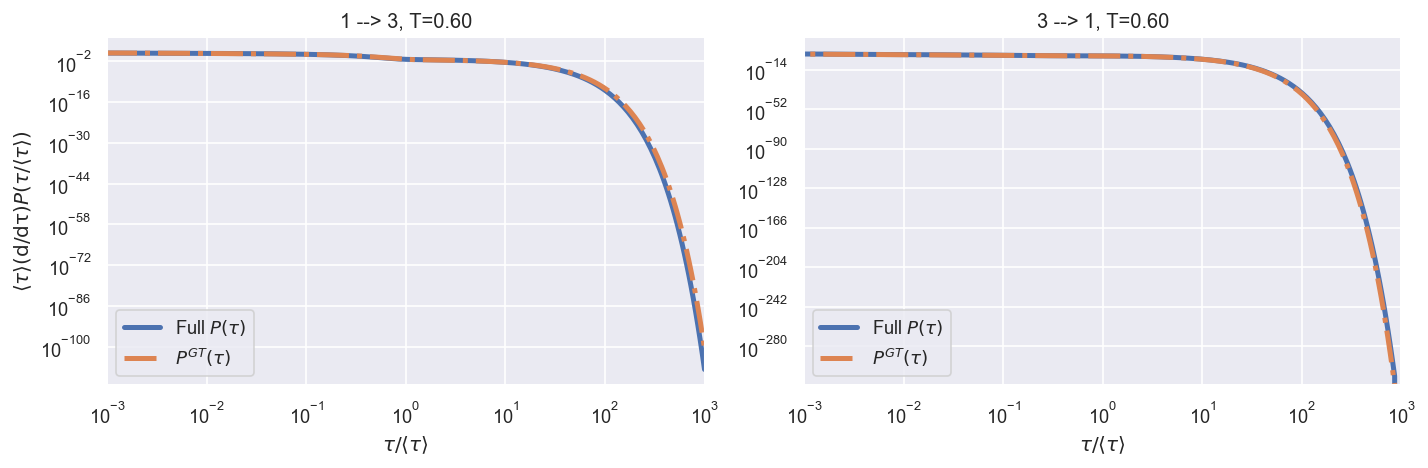

In [166]:
plot_ptAB_full_vs_reduced(1, 3, communities_free20, BF_free20, Q_free20, ratio=False)

N,N_TS: 998 3981
MFPT 1->3 reduced/full: 0.9467268346069109
sigma 1->3 reduced/full: 0.9566614800367578
MFPT 3->1 reduced/full: 1.227105016619213
sigma 3->1 reduced/full: 1.3927434118566462


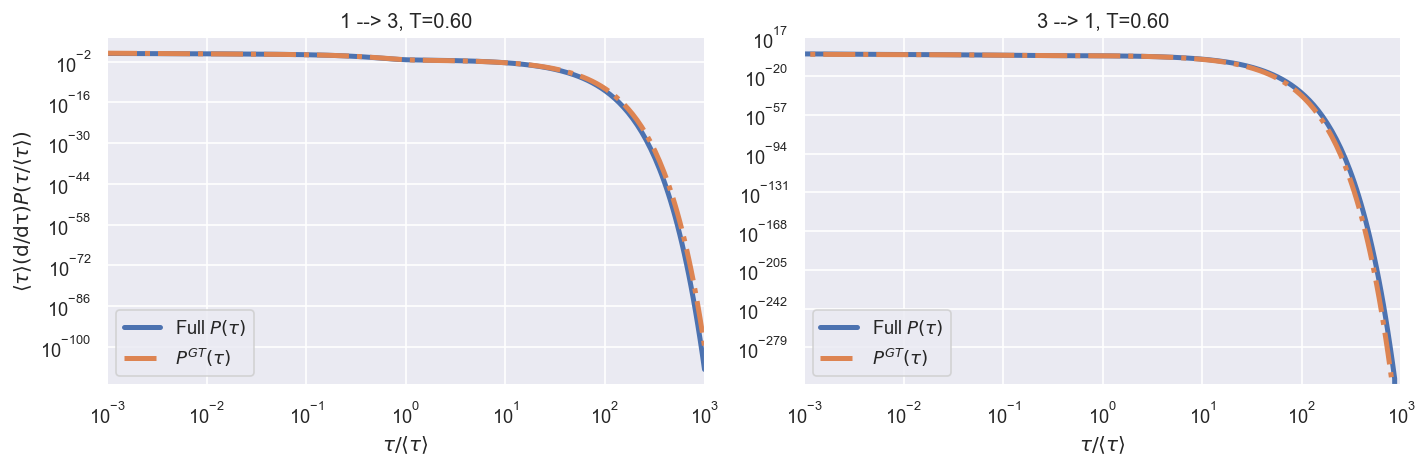

In [167]:
plot_ptAB_full_vs_reduced(1, 3, communities_hybrid20, BF_hybrid20, Q_hybrid20, ratio=False)

N,N_TS: 998 3981
MFPT 1->4 reduced/full: 2.2828982331167476
sigma 1->4 reduced/full: 2.847708967062275
MFPT 4->1 reduced/full: 1.3549107255476849
sigma 4->1 reduced/full: 1.735763886630751


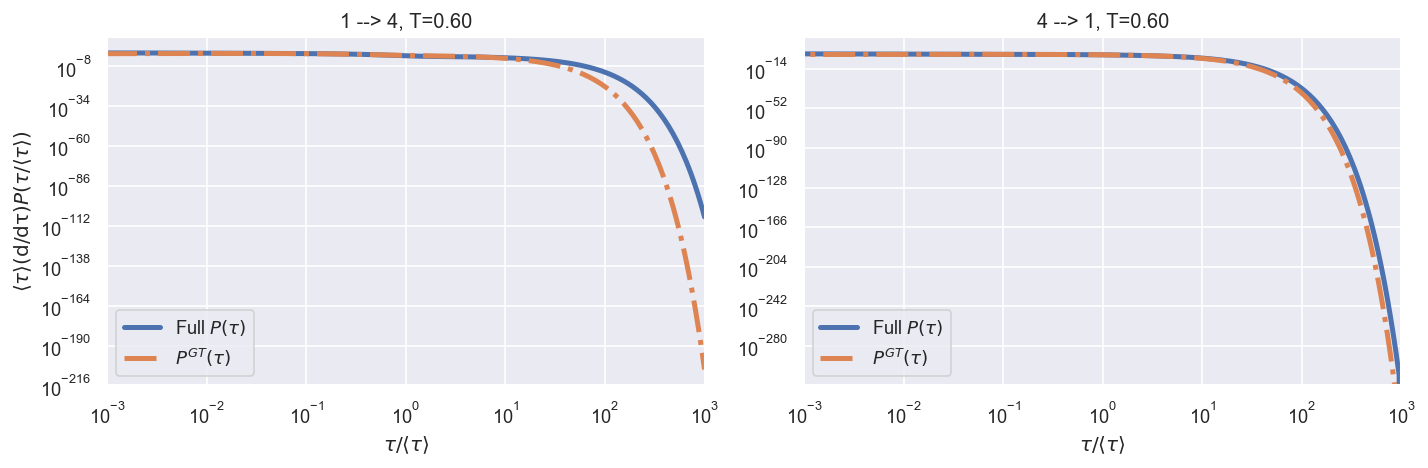

In [168]:
plot_ptAB_full_vs_reduced(1, 4, communities_free20, BF_free20, Q_free20, ratio=False)

N,N_TS: 998 3981
MFPT 1->4 reduced/full: 1.0689356348814323
sigma 1->4 reduced/full: 1.0850790375961217
MFPT 4->1 reduced/full: 1.304837463192884
sigma 4->1 reduced/full: 1.6052695033492308


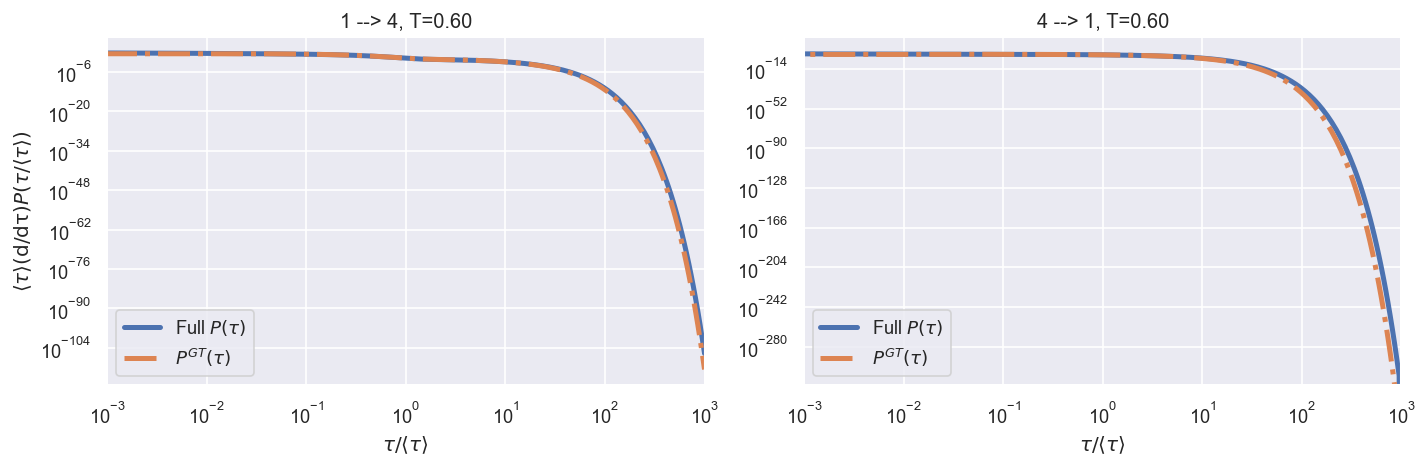

In [169]:
plot_ptAB_full_vs_reduced(1, 4, communities_hybrid20, BF_hybrid20, Q_hybrid20, ratio=False)

N,N_TS: 998 3981
MFPT 0->1 reduced/full: 1.314649894069125
sigma 0->1 reduced/full: 1.670965699494659
MFPT 1->0 reduced/full: 1.1326629572716536
sigma 1->0 reduced/full: 1.3123101053227069


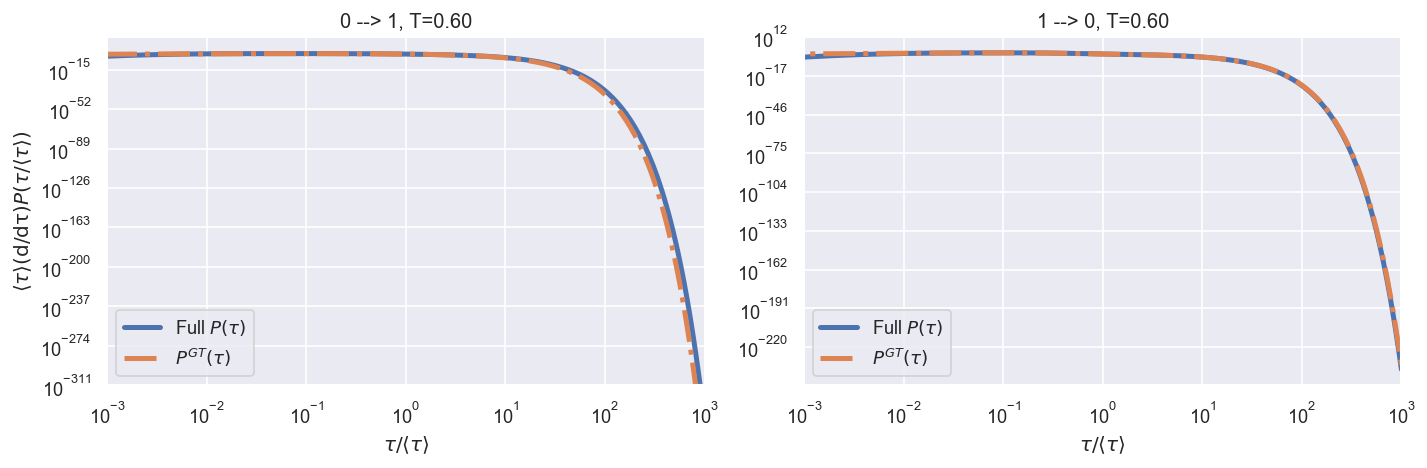

In [170]:
plot_ptAB_full_vs_reduced(0, 1, communities_free20, BF_free20, Q_free20, ratio=False)

N,N_TS: 998 3981
MFPT 0->1 reduced/full: 1.2681741656162209
sigma 0->1 reduced/full: 1.5488323703390425
MFPT 1->0 reduced/full: 1.1413296569744638
sigma 1->0 reduced/full: 1.320040655838042


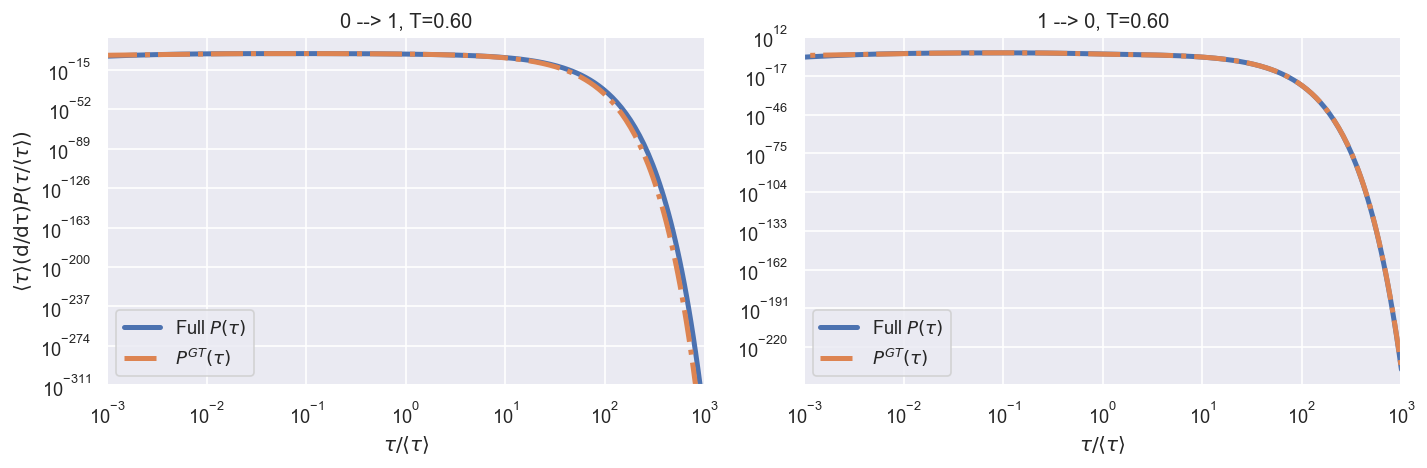

In [171]:
plot_ptAB_full_vs_reduced(0, 1, communities_hybrid20, BF_hybrid20, Q_hybrid20, ratio=False)

N,N_TS: 998 3981
MFPT 2->3 reduced/full: 0.9119620815637577
sigma 2->3 reduced/full: 0.7683396978890845
MFPT 3->2 reduced/full: 4.1485630116210075
sigma 3->2 reduced/full: 33.897768107277194


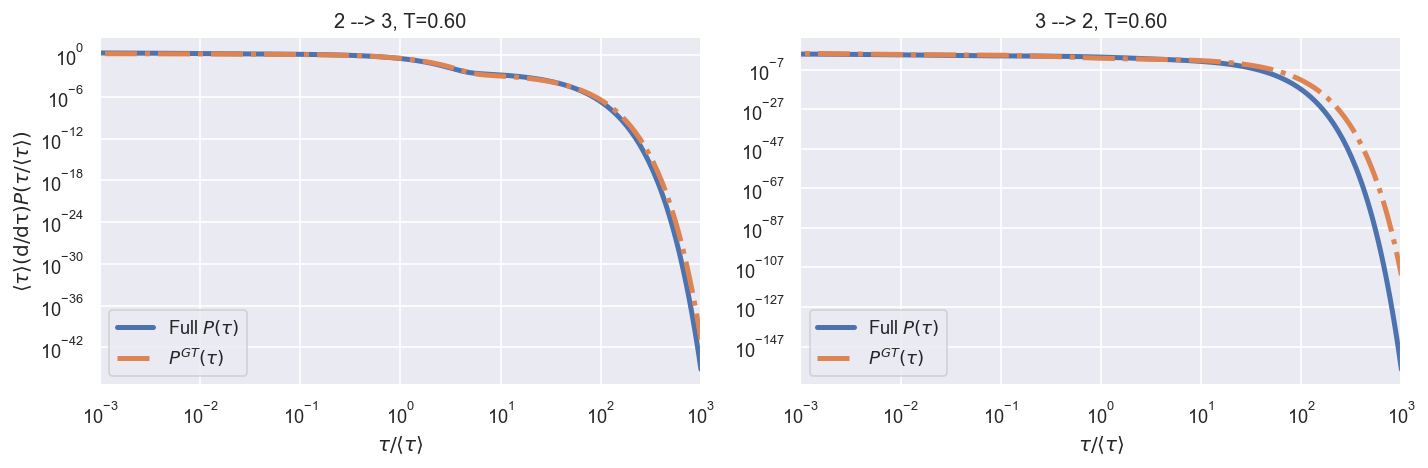

In [172]:
plot_ptAB_full_vs_reduced(2, 3, communities_free20, BF_free20, Q_free20, ratio=False)

N,N_TS: 998 3981
MFPT 2->3 reduced/full: 0.9615784565699539
sigma 2->3 reduced/full: 0.8949555568468929
MFPT 3->2 reduced/full: 0.931119293761718
sigma 3->2 reduced/full: 0.8796532042854269


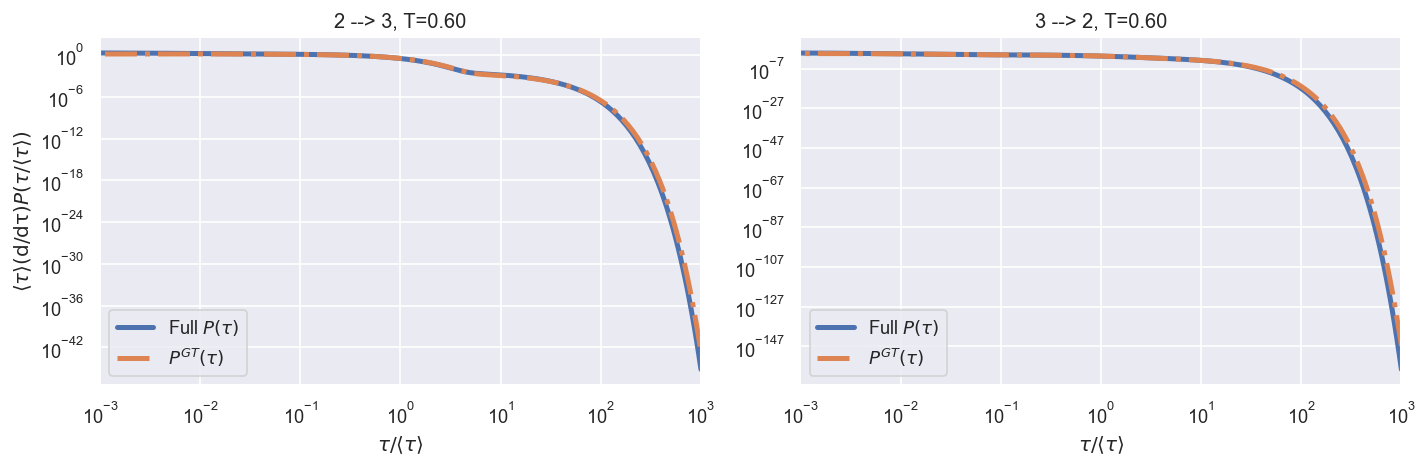

In [173]:
plot_ptAB_full_vs_reduced(2, 3, communities_hybrid20, BF_hybrid20, Q_hybrid20, ratio=False)

N,N_TS: 998 3981
MFPT 0->2 reduced/full: 8.096154833256195
sigma 0->2 reduced/full: 49.54647034346159
MFPT 2->0 reduced/full: 1.158179465919771
sigma 2->0 reduced/full: 1.326917056840391


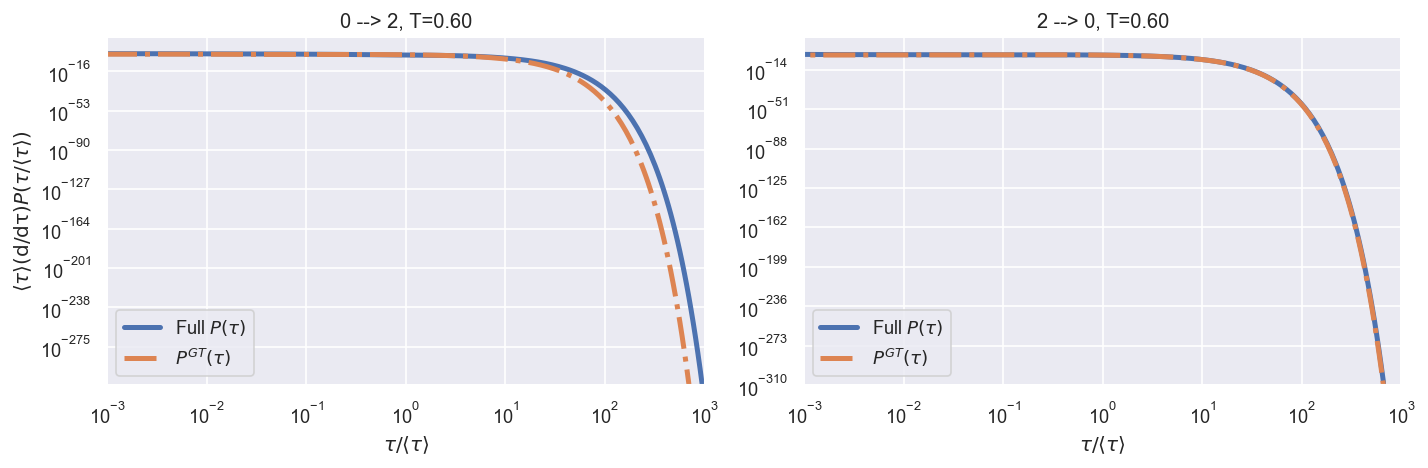

In [174]:
plot_ptAB_full_vs_reduced(0, 2, communities_free20, BF_free20, Q_free20, ratio=False)

N,N_TS: 998 3981
MFPT 0->2 reduced/full: 1.022311250768998
sigma 0->2 reduced/full: 1.0280690465694895
MFPT 2->0 reduced/full: 1.1557468560197808
sigma 2->0 reduced/full: 1.321081592159184


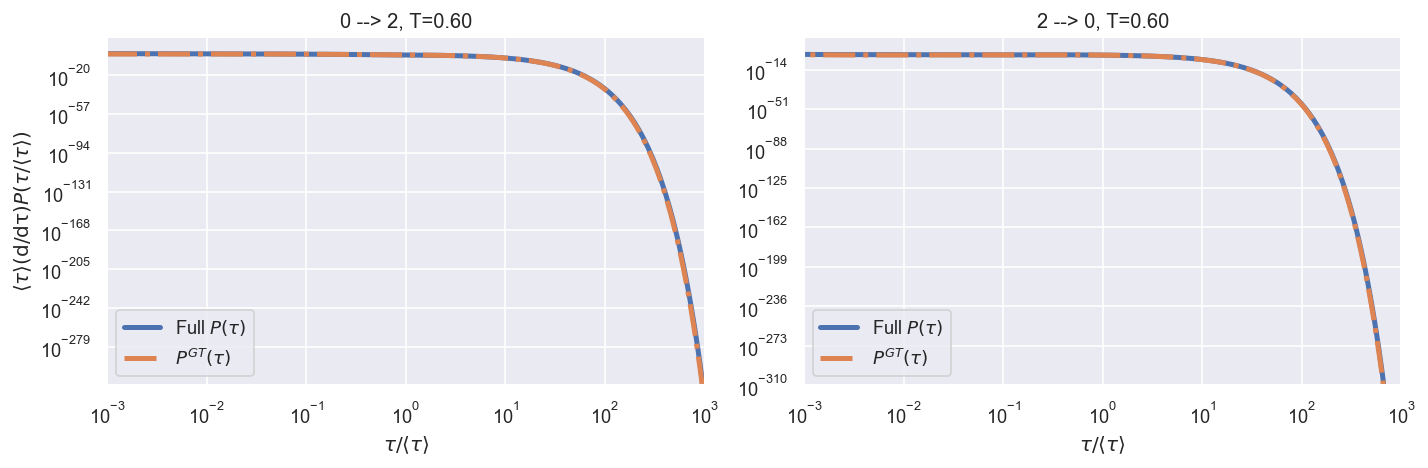

In [175]:
plot_ptAB_full_vs_reduced(0, 2, communities_hybrid20, BF_hybrid20, Q_hybrid20, ratio=False)

In [184]:
mfpt_ratios_free20, std_ratios_free20 = get_first_second_moment_ratios_reduced_full(communities_free20, BF_free20, Q_free20)

N,N_TS: 998 3981


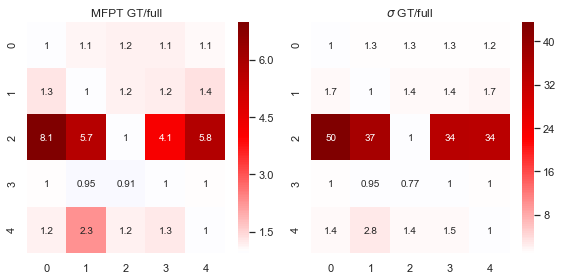

In [191]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))
sns.heatmap(mfpt_ratios_free20, center=1.0, annot=True, robust=True, cmap='seismic', ax=ax0)
sns.heatmap(std_ratios_free20, center=1.0, annot=True, robust=True, cmap='seismic', ax=ax1)
ax0.set_title('MFPT GT/full')
ax1.set_title(r'$\sigma$ GT/full')
fig.tight_layout()

* when 2 is the absorbing basin, the MFPT's from all 4 other communities are extremely off when using free energy as the basis for pruning nodes

In [189]:
mfpt_ratios_hybrid20, std_ratios_hybrid20 = get_first_second_moment_ratios_reduced_full(communities_hybrid20, BF_hybrid20, Q_hybrid20)

N,N_TS: 998 3981


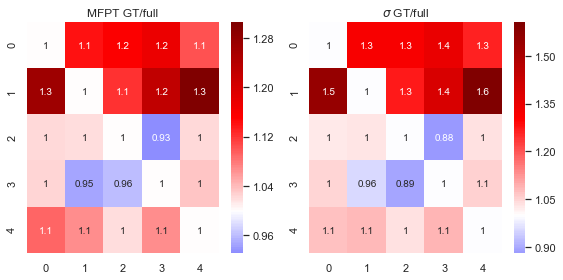

In [190]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))
sns.heatmap(mfpt_ratios_hybrid20, center=1.0, annot=True, cmap='seismic', ax=ax0)
sns.heatmap(std_ratios_hybrid20, center=1.0, annot=True, cmap='seismic', ax=ax1)
ax0.set_title('MFPT GT/full')
ax1.set_title(r'$\sigma$ GT/full')
fig.tight_layout()

* In contrast, using the hybrid approach seems to get all pairwise community <--> community passage time first and second moments accurate
* first and second moments are all within a factor of 2 of the right answer
* Since all of these communities are fairly metastable, all inter community rates k* = 1/<tau*>, so as long as we are confident in first moment, we can reasonably predict inter-community rates using the reduced network
* In the hybrid approach, the most erroneous set of MFPTs are those where basin 1 is absorbing.

### First and Second Moments at different temperatures

In [221]:
def plot_escapeB_moments(tau, tau_fulls):
    fig,ax = plt.subplots(figsize=(10,4),dpi=120)
    names=['oct','ico']
    size=[5,128]
    ax.set_title("Escape from iso")
    ax.plot(data[:,0],data[:,1],'C0-',lw=3,label=r"$\langle\tau\rangle_\mathcal{B}$")
    ax.plot(data[:,0],np.sqrt(data[:,2]-data[:,1]**2),'C2-.',lw=3,label=r"$\sigma_\mathcal{B}$")

    ax.plot(data[:,0],data[:,3],'C1--',lw=3,label=r"$\langle\tau\rangle_\mathcal{B}$ (GT)")
    ax.plot(data[:,0],np.sqrt(data[:,4]-data[:,3]**2),'C3--',lw=3,label=r"$\sigma_\mathcal{B}$ (GT)")

        #ax[j].plot(data[:,0],data[:,9+2*j],'C4--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
        #ax[j].plot(data[:,0],np.sqrt(data[:,10+2*j]-data[:,9+2*j]**2),'C5--',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
    ax.set_xlabel("Inverse Temperature")
    ax.set_ylabel("Time")
    ax.legend()
    ax.set_yscale("log")
    plt.tight_layout()

def plot_first_second_moment_reduced_full(betas, rm_type='hybrid'):
    #first row first moment, second row second moment
    data_path = Path("KTN_data/3h")
    fig, ax = plt.subplots(1, 5, figsize=(15,3),dpi=120)#,sharex='col')
    for j in range(5):
        ax[j].set_title(f"Escape from {j}")
        taus = np.zeros((2, len(betas))) #reduced network
        tau_fulls = np.zeros((2, len(betas))) #full network
        for i, beta in enumerate(betas):
            B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
            communities = read_communities(data_path/'communities_3h.dat', index_sel)
            D = np.ravel(K.sum(axis=0))
            Q = diags(D)-K
            BF = beta*u-s
            BF -= BF.min()
            #first compute escape time moments from each basin in full network
            tau_full = compute_escape_stats(communities[j], BF, Q, dopdf=False)
            #reduced network
            results, B, D, Q_reduced, N_reduced, BF_reduced, comms_reduced = prune_B_sequential(beta, percent_retained_in_B=20., rm_type=rm_type, dopdf=False)
            tau = compute_escape_stats(comms_reduced[j], BF_reduced, Q_reduced, dopdf=False)
            taus[:, i] = tau
            tau_fulls[:, i] = tau_full
        print(taus.shape, tau_fulls.shape, betas.shape)
        ax[j].plot(betas, tau_fulls[0, :], 'C0-', lw=3, label=r"$\langle\tau\rangle$")
        ax[j].plot(betas, tau_fulls[1, :], 'C2-.', lw=3, label=r"$\sigma$")
        ax[j].plot(betas, taus[0, :], 'C1--', lw=3, label=r"$\langle\tau\rangle$ (GT)")
        ax[j].plot(betas, taus[1, :], 'C3--', lw=3, label=r"$\sigma$ (GT)")
        if j==2:
            ax[j].set_xlabel(r"$1/T$")
        if j==0:
            ax[j].set_ylabel("Time")
        ax[j].legend()
        ax[j].set_yscale('log')
    fig.tight_layout()

N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 165
382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 165
382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)

N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 166
381 (381, 381) (381,) (381,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 184
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 166
381 (381, 381) (381,) (381,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 184
(2, 20) (2, 20) (20,)
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (9

381 (381, 381) (381,) (381,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 184
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 166
381 (381, 381) (381,) (381,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 184
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 166
381 (381, 381) (381,) (381,)
Source comm: 2, Source nodes: 232

382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 184
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 165
382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 184
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 166
381 (381, 381) (381,) (381,)
Source comm: 2, Source nodes: 232

382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 165
382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 184
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 165
382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232

682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 165
382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 135
547 (547, 547) (547,) (547,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 165
382 (382, 382) (382,) (382,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 130
868 (868, 868) (868,) (868,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 186
682 (682, 682) (682,) (682,)
Source comm: 4, Source nodes: 171

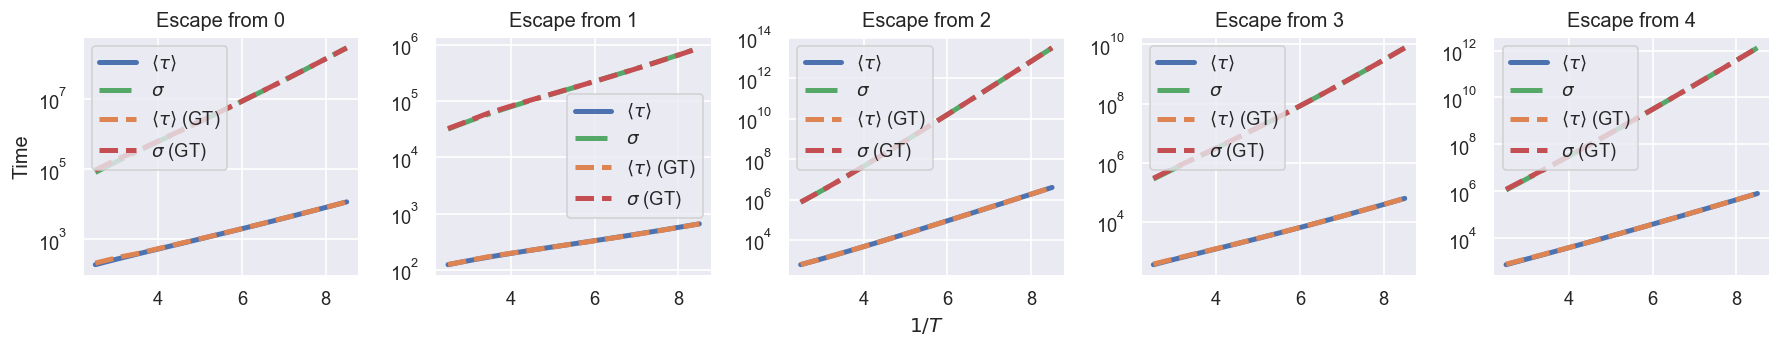

In [220]:
plot_first_second_moment_reduced_full(np.linspace(2.5,8.5,20))

N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)

N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
(2, 20) (2, 20) (20,)
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (9

686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171

N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, 

386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232

550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205
Nodes to eliminate: 164
386 (386, 386) (386,) (386,)
Source comm: 2, Source nodes: 232
Nodes to eliminate: 185
N,N_TS: 998 3981
N,N_TS: 998 3981
998 (998, 998) (998,) (998,)
Source comm: 0, Source nodes: 160
Nodes to eliminate: 128
870 (870, 870) (870,) (870,)
Source comm: 1, Source nodes: 230
Nodes to eliminate: 184
686 (686, 686) (686,) (686,)
Source comm: 4, Source nodes: 171
Nodes to eliminate: 136
550 (550, 550) (550,) (550,)
Source comm: 3, Source nodes: 205

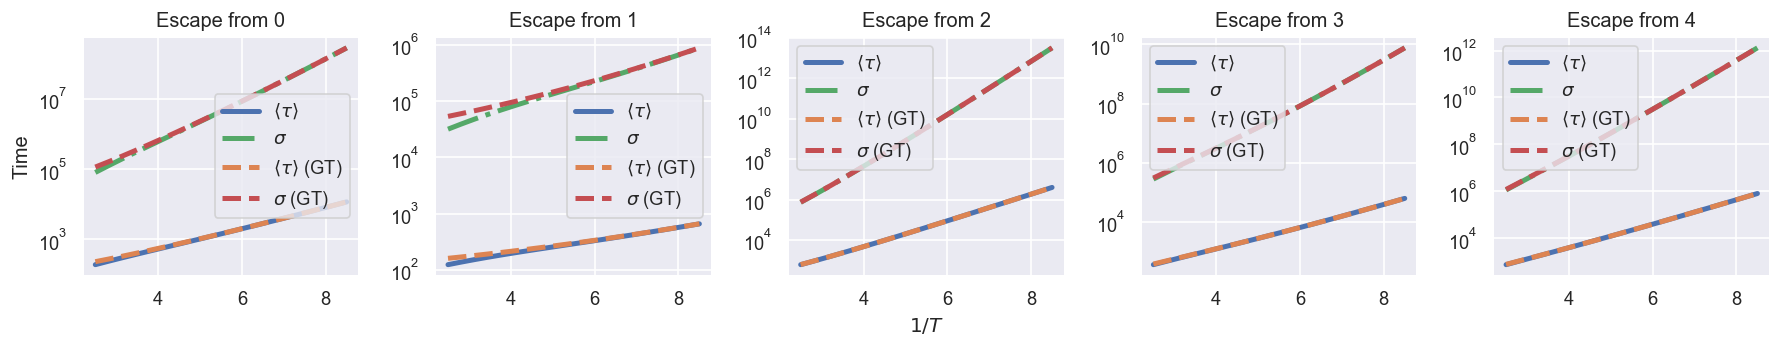

In [222]:
plot_first_second_moment_reduced_full(np.linspace(2.5,8.5,20), rm_type='free_energy')